In [1]:
import matplotlib.pyplot as plt
%pylab inline

import seaborn as sns
sns.set()

import numpy as np

import multiprocessing as mp

from tqdm import tqdm

from functools import partial

%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


# Estimation of constant via Monte-Carlo

In [2]:
δ = 0.05
q_alpha = (100*δ)/2

linspace_size = 50
n_samples = np.linspace(100, 1e4, linspace_size, dtype=int)
n_replications = 1000

In [3]:
def plot_percentiles(n_samples, theta_hist, q_alpha):
    plt.plot(n_samples, np.percentile(theta_hist, 100-q_alpha, axis=1), label='(1 - δ)-percentile')
    plt.plot(n_samples, np.percentile(theta_hist, q_alpha, axis=1), label='δ-percentile')
    plt.xlabel('Number of samples')
    plt.legend()

## Squared loss and Gaussian observations

Assume $Y_1, \dots, Y_n$ are i.i.d. standard Gaussian random variables and the loss $\phi$ is given by $\phi(x, y) = (x-y)^2, \forall x,y$.

We have $\hat{\theta}_n = \frac{1}{n}\sum_{i=1}^n Y_i$ and $\theta^* = 0$. 


- Assumption 2.1 holds since $Y$ has a finite expectation

Using the fact that $\phi(y, \theta) - \phi(y, 0)= \theta^2 - 2 \theta y$ we have

- Assumption 2.2 holds with $r=+\infty, \alpha=2$
- Assumption 2.3 holds with $\sigma=2$.

Thus Theorem 2 from the paper (with $\varepsilon=1$) tells us that, for any $\delta \in (0, 1/17)$, with probability at least $1-\delta$,
\begin{align}
\lvert \hat{\theta}_n - \theta^* \rvert \le 4\sqrt{2} \sqrt{\frac{2\ln \ln n + \ln(17/\delta)}{n}}
\end{align}

We want to study the empirical behavior of $\hat{\theta}_n$ to see if our bound is tight.

100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


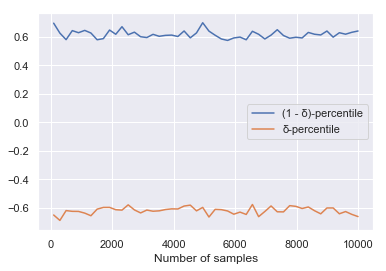

In [73]:
theta_hist = np.zeros((linspace_size, n_replications))

p = Pool(multiprocessing.cpu_count())

for idx, n in enumerate(tqdm(n_samples)):
    
    # draw random variables
    Y = np.random.normal(0, 1, n*n_replications)    
    Y_sliced = [Y[k*n:(k+1)*n] for k in range(n_replications)]
    
    theta_hat = np.array(list(p.map(np.mean, Y_sliced)))
    
    theta_hist[idx, :] = np.sqrt(n/(2*np.log(np.log(n)) + np.log(17/δ)))*theta_hat
    
p.close()

plot_percentiles(n_samples, theta_hist, q_alpha)

The plot above shows the empirical percentiles of the distribution of $\sqrt{\frac{n}{2\ln \ln n + \ln (17/\delta)}} \hat{\theta}_n$ as $n$ grows. It seems to be roughly constant and is comprised between 1 and 2 in absolute value.

## Absolute loss and Gaussian observations

Assume $Y_1, \dots, Y_n$ are i.i.d. standard Gaussian random variables and the loss $\phi$ is given by $\phi(x, y) = \lvert x-y \rvert, \forall x,y$.

- Assumption 2.1 is verified since $Y$ has an expectation

We have $\Phi''(\theta) = \sqrt{\frac{2}{\pi}}\exp^{-\theta^2/2}$

- Assumption 2.2 holds for $r=1$ and $\alpha=0.48$ for example

The triangular inequality yields $\lvert \phi(Y, \theta) - \phi(Y, 0) \rvert= \lvert \lvert Y - \theta \rvert - \lvert Y \rvert \rvert  \leq \theta$ thus

- Assumption 2.3 holds for $\sigma=1$.

Thus Theorem 2 from the paper (with $\varepsilon=1$) tells us that, for any $\delta \in (0, 1/17)$, with probability at least $1-\delta$,
\begin{align}
\lvert \hat{\theta}_n - \theta^* \rvert \le 10\sqrt{2} \sqrt{\frac{2\ln \ln n + \ln(17/\delta)}{n}}
\end{align}


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]


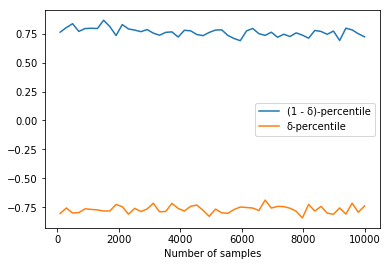

In [23]:
theta_hist = np.zeros((linspace_size, n_replications))
for idx, n in enumerate(tqdm(n_samples)):
    theta_hat = np.array([np.median(np.random.normal(0, 1, n)) for k in range(n_replications)])
    theta_hist[idx, :] = np.sqrt(n/(2*np.log(np.log(n)) + np.log(17/δ)))*theta_hat
plot_percentiles(n_samples, theta_hist, q_alpha)

## Absolute loss and Cauchy observations

100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


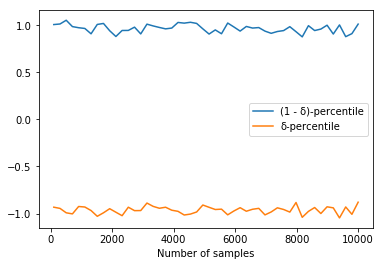

In [24]:
theta_hist = np.zeros((linspace_size, n_replications))
for idx, n in enumerate(tqdm(n_samples)):
    theta_hat = np.array([np.median(np.random.standard_cauchy(n)) for k in range(n_replications)])
    theta_hist[idx, :] = np.sqrt(n/(2*np.log(np.log(n)) + np.log(17/δ)))*theta_hat

plot_percentiles(n_samples, theta_hist, q_alpha)

## Conclusions
- our theoretical constants are bigger than the empirical constants we estimated on the three examples.
- the convergence rate seems to be tight (the empirical quantiles multiplied by the rate are roughly constant across the number of samples).
- we don't observe a warm-up time $n_0$ in practice

# Robust lil UCB vs vanilla lil UCB

Express the number of pulls as a function of the number of the number of arms.

## Contamination model

In [3]:
%autoreload
from ucb_classes import lilUCB, robust_lilUCB
from mab_class import MAB

In [4]:
def robust_lilUCB_exp(mab, K):    
    robust_lilUCB_proc = robust_lilUCB(δ=0.1, ϵ=0.01, β=1, K=K)
    
    T = robust_lilUCB_proc.run(mab)
    
    return np.sum(T), np.argmax(T)

In [5]:
def lilUCB_exp(mab, K):    
    lilUCB_proc = lilUCB(δ=0.1, ϵ=0.01, β=1, K=K)
    
    T = lilUCB_proc.run(mab)
    
    return np.sum(T), np.argmax(T)

In [7]:
#%load_ext line_profiler

In [59]:
K = 1000

mab = MAB(K, 'sparse', 'gaussian')

lilUCB_proc = lilUCB(δ=0.1, ϵ=0.01, β=1, K=K)

# lilUCB 
%lprun -f lilUCB_proc.run lilUCB_proc.run(mab)

In [13]:
K = 100

mab = MAB(K, 'sparse', 'gaussian')

robust_lilUCB_proc = robust_lilUCB(δ=0.1, ϵ=0.01, β=1, K=K)

# lilUCB 
%lprun -f robust_lilUCB_proc.run robust_lilUCB_proc.run(mab)

In [8]:
nb_of_arms = np.logspace(1, 3, 3, dtype=int)

n_repeat = 100

BAI_lilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
BAI_lilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
BAI_robustlilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
BAI_robustlilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)

nb_of_pulls_lilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
nb_of_pulls_lilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
nb_of_pulls_robustlilUCB_huber = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)
nb_of_pulls_robustlilUCB = np.zeros((nb_of_arms.shape[0],n_repeat), dtype=int)

p = mp.Pool(mp.cpu_count())

for i, K in enumerate(tqdm(nb_of_arms)): 
    
    mab = MAB(K, 'sparse', 'gaussian')
    
    # lilUCB 
    f = partial(lilUCB_exp, mab)
    result = np.array(p.map_async(f, [K]*n_repeat).get())
    nb_of_pulls_lilUCB[i, :] = result[:,0]
    BAI_lilUCB[i, :] = result[:, 1]

    # robust lil UCB
    f = partial(robust_lilUCB_exp, mab)
    result = np.array(p.map_async(f, [K]*n_repeat).get())
    nb_of_pulls_robustlilUCB[i, :] = result[:,0]
    BAI_robustlilUCB[i, :] = result[:, 1]

    mab = MAB(K, 'sparse', 'huber')
    
    # lilUCB contaminated 
    f = partial(lilUCB_exp, mab)
    result = np.array(p.map_async(f, [K]*n_repeat).get())
    nb_of_pulls_lilUCB_huber[i, :] = result[:,0]
    BAI_lilUCB_huber[i, :] = result[:, 1]

    # robust lilUCB contaminated 
    f = partial(robust_lilUCB_exp, mab)
    result = np.array(p.map_async(f, [K]*n_repeat).get())
    nb_of_pulls_robustlilUCB_huber[i, :] = result[:,0]
    BAI_robustlilUCB_huber[i, :] = result[:, 1]
        
p.close()

100%|██████████| 3/3 [27:16<00:00, 485.62s/it]


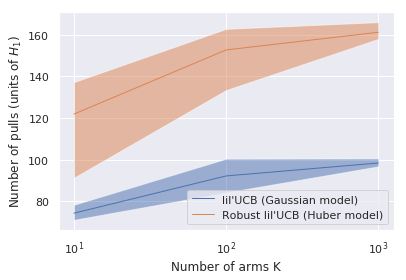

In [37]:
sns.set()

H_1 = [4*K for K in nb_of_arms]
plt.plot(nb_of_arms, np.mean(nb_of_pulls_lilUCB, axis=1)/H_1, linewidth=1)

plt.fill_between(nb_of_arms, np.percentile(nb_of_pulls_lilUCB, q=99, axis=1)/H_1, 
                 np.percentile(nb_of_pulls_lilUCB, axis=1, q=1)/H_1, alpha=.5)

plt.semilogx(nb_of_arms, np.mean(nb_of_pulls_robustlilUCB_huber, axis=1)/H_1, linewidth=1)
plt.fill_between(nb_of_arms, np.percentile(nb_of_pulls_robustlilUCB_huber, q=99, axis=1)/H_1, 
                 np.percentile(nb_of_pulls_robustlilUCB_huber, q=1, axis=1)/H_1, alpha=.5)

plt.xlabel('Number of arms K')
plt.ylabel('Number of pulls (units of $H_1$)')
plt.legend(["lil'UCB (Gaussian model)", "Robust lil'UCB (Huber model)"], loc='lower right')
savefig('number_of_pulls.pdf', bbox_inches='tight', dpi=500)

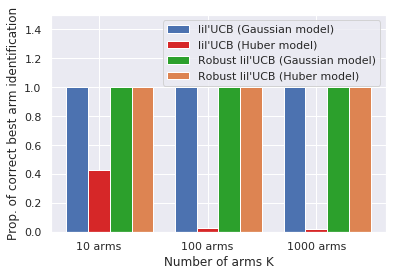

In [38]:
ind = np.array([10, 20, 30])
width = 2

prop_1 = np.sum(BAI_lilUCB==0, axis=1)/n_repeat
prop_2 = np.sum(BAI_lilUCB_huber==0, axis=1)/n_repeat
prop_3 = np.sum(BAI_robustlilUCB==0, axis=1)/n_repeat
prop_4 = np.sum(BAI_robustlilUCB_huber==0, axis=1)/n_repeat

## the bars
rects1 = plt.bar(ind, prop_1, width)
rects2 = plt.bar(ind+width, prop_2, width, color='#d62728')
rects3 = plt.bar(ind+2*width, prop_3, width, color='#2ca02c')
rects4 = plt.bar(ind+3*width, prop_4, width)
plt.xlabel('Number of arms K')
plt.ylabel('Prop. of correct best arm identification')
plt.legend(["lil'UCB (Gaussian model)", "lil'UCB (Huber model)", 
            "Robust lil'UCB (Gaussian model)","Robust lil'UCB (Huber model)"])
plt.ylim(0, 1.5)
plt.xticks(ind+width, ["{} arms".format(x) for x in nb_of_arms])
savefig('prop_correct_bai.pdf', bbox_inches='tight', dpi=500)

# Compare LIL bound to union bound 

In [4]:
def UB(n, δ):
    return np.sqrt(np.log(n/δ)/n)

def LIL(n, δ):
    return np.sqrt((2*np.log(np.log(n)) + np.log(1/δ))/n)

/Users/Schreuder/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


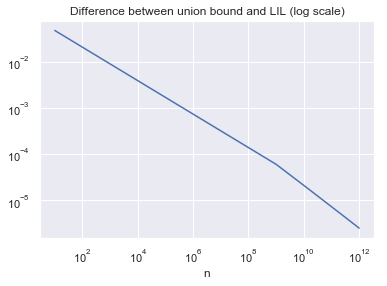

In [5]:
n = np.linspace(1e1, 1e12, 1e3, dtype=int)

δ=0.1
plt.loglog(n, UB(n, δ)- LIL(n, δ))
plt.xlabel('n')
plt.title('Difference between union bound and LIL (log scale)')